In [1]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from textwrap import wrap
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from glob import glob
import PIL
import re
import random


# for data preparation and others
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

# models tried
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [2]:
#Data Preprocessing

df = pd.read_csv("df_new.csv", delimiter=",", header = None)
X = df.iloc[1:]
X = np.asarray(X.values)
X = np.delete(X, 0, 1)
X = np.transpose(X)

y = df.iloc[0]
y = y[1:]
y = np.asarray(y)
y = np.transpose(y)

features_names = df.iloc[1:]
features_names = features_names.iloc[:,0]
features_names = np.asarray(features_names)
target_names = df.iloc[0]
target_names = target_names[1:]
target_names = np.asarray(target_names)
target_names = np.transpose(target_names)


indx = []
for i in range(len(features_names)):
  indx.append(i)
print(len(features_names))

60488


In [3]:
y.size

549

In [4]:
#y_sh1 = np.zeros(54, dtype=str)
#y_sh2 = np.ones(495, dtype=str)

In [5]:
#y_sh = np.concatenate((y_sh1, y_sh2), axis=None)

In [6]:
#for i in range(0, y_sh.size):
    #if (y_sh[i] == ''):
        #y_sh[i] = "Primary Tumor"
    #if (y_sh[i] == '1'):
        #y_sh[i] = "Solid Tissue Normal"
       

In [7]:
#splitting the data into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
#normalizing or scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [8]:
#filter technique (Mutual Information [MI])
startTime = time.time()
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', n_neighbors=3, copy=True, random_state=42)
endTime = time.time()
print('Time: ' + str(endTime - startTime))


Time: 95.0857446193695


In [9]:
#oraganizing MI data
gains = np.asarray(mi)
indexes = np.where(gains != 0)[0]
print(len(indexes))


45292


In [10]:
#Confusion matrix (19 features of MI) *******
#changing the class to discrete numbers for ROC AUC calculation
ss = 0
pp = 0
y_binary = y.copy()

for i in range(0, y_binary.size):
    if (y_binary[i] == "Primary Tumor"):
        y_binary[i] = int(0)
        pp = pp + 1
    if (y_binary[i] == "Solid Tissue Normal"):
        y_binary[i] = int(1)
        ss = ss + 1
y_binary=y_binary.astype('int')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-19:]
startTime = time.time()
x_train = X_train[:, it]
x_test = X_test[:, it]
Y_train = y_train[:]
Y_test = y_test[:]
x_train = x_train.astype('float32')
X_test = x_test.astype('float32')

clf = LinearSVC(random_state=42)
clf.fit(x_train, Y_train)
scores = clf.score(x_test, Y_test)
endTime = time.time()
print('Score: ' + str(scores))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(x_test)


print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))

print(balanced_accuracy_score(y_test, y_pred))




Score: 0.9863636363636363
Time: 0.4754002094268799
[[198   0]
 [  3  19]]
                     precision    recall  f1-score   support

      Primary Tumor       0.99      1.00      0.99       198
Solid Tissue Normal       1.00      0.86      0.93        22

           accuracy                           0.99       220
          macro avg       0.99      0.93      0.96       220
       weighted avg       0.99      0.99      0.99       220

0.9863636363636363
(0.9865671641791044, 0.9863636363636363, 0.9859160095360352, None)
0.9318181818181819


In [11]:
#to get the common features between top 19 MI features and the features of the 345 trees in the Random forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
ST = time.time()
regressor = RandomForestClassifier(n_estimators=345, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
sorted_features = sorted (zip(map(lambda x: round(x, 4), regressor.feature_importances_), indx),reverse=True)
important_f = []
  

for s in sorted_features:
  if s[0] != 0:
    important_f.append(s[1])
important_f = np.transpose(important_f)
important_f = np.asarray(important_f)

#checking the similarities in the first 19 features in MI with features used in RF (n_estimators = 345)
it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-19:]
similarity = []
count = 0
for f in important_f:
  for t in it:
    if (f == t):
      count = count + 1
      similarity.append(f)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))
print("the number of important features used: ", len(important_f))
print ("number of similar features: ", len(similarity))  

ET = time.time()
print("time: ", ET - ST)
print("\n")
print(balanced_accuracy_score(y_test, y_pred))

0.9863636363636363
[[198   0]
 [  3  19]]
                     precision    recall  f1-score   support

      Primary Tumor       0.99      1.00      0.99       198
Solid Tissue Normal       1.00      0.86      0.93        22

           accuracy                           0.99       220
          macro avg       0.99      0.93      0.96       220
       weighted avg       0.99      0.99      0.99       220

(0.9865671641791044, 0.9863636363636363, 0.9859160095360352, None)
the number of important features used:  1261
number of similar features:  18
time:  1.9994032382965088


0.9318181818181819


In [12]:
#The wrapper method (recursive feature elimination RFE) 76 features only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

startTime = time.time()
estimator = LinearSVC(random_state=42)
selector = RFE(estimator, n_features_to_select= 76, step=0.5)
selector = selector.fit(X_train, y_train)
endTime = time.time()
print('Time: ' + str(endTime - startTime))
# testing the model
y_pred = selector.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(selector.score(X_test, y_test))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))

print(np.count_nonzero(selector.support_ == 1))
print(balanced_accuracy_score(y_test, y_pred))

(329, 60488)
(329,)
(220, 60488)
(220,)
Time: 3.228322744369507
0.9772727272727273
0.9772727272727273
[[195   3]
 [  2  20]]
                     precision    recall  f1-score   support

      Primary Tumor       0.99      0.98      0.99       198
Solid Tissue Normal       0.87      0.91      0.89        22

           accuracy                           0.98       220
          macro avg       0.93      0.95      0.94       220
       weighted avg       0.98      0.98      0.98       220

(0.9778194659015669, 0.9772727272727273, 0.9774964838255977, None)
76
0.946969696969697


In [13]:
#Create a list with indices of RFE Features
RFE_features = np.where(selector.support_ == 1)
RFE_features = np.asarray(RFE_features)
rfe_f = []
for i in RFE_features:
  for s in i:
    rfe_f.append(s)
rfe_f = np.asarray(rfe_f)

In [14]:
#Create list with common features among techniques
similar_all = []
similar_rfe_RF = []
similar_rfe_MI = []

count = 0
for f in it:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_rfe_MI.append(f)
print("number of similar features between RFE and MI: ", count)

count = 0
for f in important_f:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_rfe_RF.append(f)
print("number of similar features between RFE and RF: ", count)

count = 0
for f in similarity:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_all.append(f)
print("number of similar features between RF and MI: ", len(similarity))
print("number of similar features between RFE, RF and MI: ", count)


number of similar features between RFE and MI:  12
number of similar features between RFE and RF:  50
number of similar features between RF and MI:  18
number of similar features between RFE, RF and MI:  12


In [15]:
#A LinearSVC Model using the similar features between all of them
startTime = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train[:, similar_all])
X_test = sc.transform(X_test[:, similar_all])

Y_train = y_train[:]
Y_test = y_test[:]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train[:]
Y_test = Y_test[:]
clf = LinearSVC(random_state=42)

clf.fit(X_train, Y_train)

endTime = time.time()
print('Score: ' + str(clf.score(X_test, Y_test)))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))
print(balanced_accuracy_score(y_test, y_pred))

Score: 0.9772727272727273
Time: 2.5510051250457764
[[197   1]
 [  4  18]]
                     precision    recall  f1-score   support

      Primary Tumor       0.98      0.99      0.99       198
Solid Tissue Normal       0.95      0.82      0.88        22

           accuracy                           0.98       220
          macro avg       0.96      0.91      0.93       220
       weighted avg       0.98      0.98      0.98       220

0.9772727272727273
(0.976826394344069, 0.9772727272727273, 0.9765266825600586, None)
0.9065656565656566


In [16]:
import random
import numpy as np
 

# A function to generate a random
# permutation of array
def shuffler (arr, n):
     
    # We will Start from the last element
    # and swap one by one.
    for i in range(n-1,0,-1):
         
        # Pick a random index from 0 to i
        
        j = random.randint(0, n-1)
         
        # Swap arr[i] with the element at random index
        arr[i],arr[j] = arr[j],arr[i]
    return arr



In [17]:
#A LinearSVC Model using the similar features between all of them
startTime = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train[:, similar_all])
X_test = sc.transform(X_test[:, similar_all])

rrr = shuffler(y_train,len(y_train))

Y_train = y_train[:]
Y_test = y_test[:]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train[:]
Y_test = Y_test[:]
clf = LinearSVC(random_state=42)
clf.fit(X_train, rrr)

endTime = time.time()
print('Score: ' + str(clf.score(X_test, Y_test)))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))


print(balanced_accuracy_score(y_test, y_pred))

Score: 0.9136363636363637
Time: 2.559307813644409
[[198   0]
 [ 19   3]]
0.5681818181818181


No Skill: ROC AUC=0.500
Model: ROC AUC=0.371


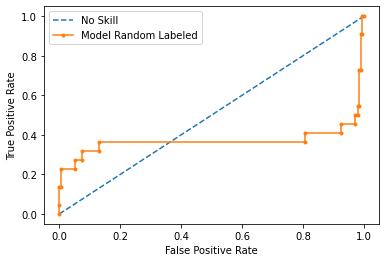

In [18]:
#ROC AUC calculations for the 76 features of RFE Model

#changing the class to discrete numbers for ROC AUC calculation
ss = 0
pp = 0
y_test_binary = y_test.copy()
y_train_binary = rrr.copy()

for i in range(0, y_test_binary.size):
    if (y_test_binary[i] == "Primary Tumor"):
        y_test_binary[i] = int(0)
        pp = pp + 1
    if (y_test_binary[i] == "Solid Tissue Normal"):
        y_test_binary[i] = int(1)
        ss = ss + 1
y_test_binary=y_test_binary.astype('int')

for i in range(0, y_train_binary.size):
    if (y_train_binary[i] == "Primary Tumor"):
        y_train_binary[i] = int(0)
        pp = pp + 1
    if (y_train_binary[i] == "Solid Tissue Normal"):
        y_train_binary[i] = int(1)
        ss = ss + 1
y_train_binary=y_train_binary.astype('int')



# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_binary))]


Y_train_binary = y_train_binary[:]
Y_test_binary = y_test_binary[:]

# predict probabilities
svm = LinearSVC(random_state=42)
model3 = RFE(svm, n_features_to_select= 76, step=0.5)
model3 = model3.fit(X_train, y_train)
lr_probs = model3.decision_function(X_test)

# calculate scores
ns_auc = roc_auc_score(Y_test_binary, ns_probs)
lr_auc = roc_auc_score(Y_test_binary, lr_probs)
# summarize scores: prints the ROC AUC for the model and the no skill classifier that only predicts 0 for all samples
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test_binary, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test_binary, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Model Random Labeled')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


In [19]:
#A LinearSVC 5-fold-Model using the similar features between all of them using random labels
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold



cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
model = LinearSVC(random_state=42)
graph_sh = []
for kk in range(0,100):

    cc = 1
    acc_f = []
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train = sc.fit_transform(X[train])
        X_train = X_train[:, similar_all]
        X_test = sc.transform(X[test])
        X_test = X_test[:,similar_all]
    
        
        y_train, y_test = y[train], y[test]
        
        rrr = shuffler(y_train,len(y_train)-1)
        # evaluate model
        model.fit(X_train, rrr)
        # evaluate model
        yhat = model.predict(X_test)
        acc_f.append(balanced_accuracy_score(y_test, yhat))
    print('Balanced Accuracy: %.4f (%.4f)' % (mean(acc_f), std(acc_f)))
    graph_sh.append(mean(acc_f))

Balanced Accuracy: 0.5172 (0.0232)
Balanced Accuracy: 0.5091 (0.0182)
Balanced Accuracy: 0.5273 (0.0364)
Balanced Accuracy: 0.5091 (0.0182)
Balanced Accuracy: 0.5081 (0.0188)
Balanced Accuracy: 0.5081 (0.0188)
Balanced Accuracy: 0.5000 (0.0000)
Balanced Accuracy: 0.5182 (0.0364)
Balanced Accuracy: 0.5080 (0.0211)
Balanced Accuracy: 0.5454 (0.0508)
Balanced Accuracy: 0.5081 (0.0188)
Balanced Accuracy: 0.5000 (0.0000)
Balanced Accuracy: 0.5444 (0.0583)
Balanced Accuracy: 0.5455 (0.0704)
Balanced Accuracy: 0.5373 (0.0343)
Balanced Accuracy: 0.5182 (0.0223)
Balanced Accuracy: 0.5263 (0.0372)
Balanced Accuracy: 0.5364 (0.0445)
Balanced Accuracy: 0.5444 (0.0914)
Balanced Accuracy: 0.5091 (0.0182)
Balanced Accuracy: 0.5182 (0.0223)
Balanced Accuracy: 0.5081 (0.0188)
Balanced Accuracy: 0.5091 (0.0182)
Balanced Accuracy: 0.5081 (0.0188)
Balanced Accuracy: 0.5727 (0.0936)
Balanced Accuracy: 0.5091 (0.0182)
Balanced Accuracy: 0.5000 (0.0000)
Balanced Accuracy: 0.5091 (0.0182)
Balanced Accuracy: 0

Text(0, 0.5, 'Balanced Accuracy')

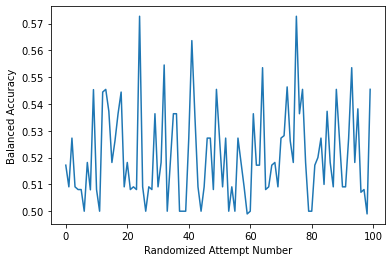

In [20]:
#Plot a graph with all accuracy scores
plt.plot(graph_sh)
plt.xlabel('Randomized Attempt Number')
plt.ylabel('Balanced Accuracy')

In [21]:
mean(graph_sh)

0.5208171717171717

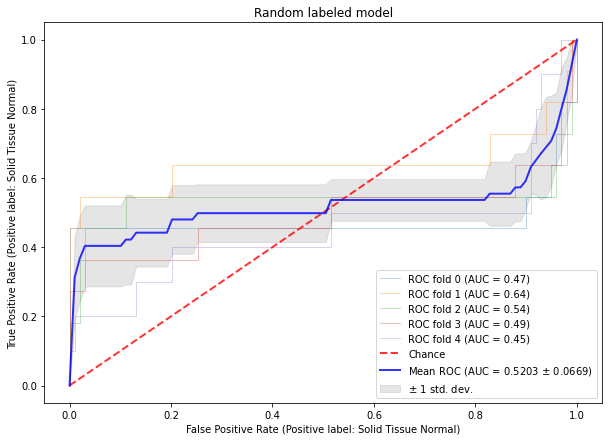

Balanced Accuracy: 0.4990 (0.0020)


In [60]:
#############################################################################
# Classification and ROC analysis for MI-SVM model




# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
classifier = LinearSVC(random_state=42)

tprs = []
aucs = []
acc = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize = (10,7))
for i, (train, test) in enumerate(cv.split(X, y)):
    X_train = sc.fit_transform(X[train])
    X_train = X_train[:, similar_all]
    X_test = sc.transform(X[test])
    X_test = X_test[:,similar_all]
    
    y_train, y_test = y[train], y[test]
    
    rrr = shuffler(y_train,len(y_train)-1)
    
    classifier.fit(X_train, rrr)
    yhat = model.predict(X_test)
    acc.append(balanced_accuracy_score(y_test, yhat))
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Random labeled model",
)
ax.legend(loc="lower right")
plt.show()


print('Balanced Accuracy: %.4f (%.4f)' % (mean(acc), std(acc)))
